# Lattices in OSCAR

### Tommy Hofmann - Universität Siegen - 31.05.2023

## Outline

1. General information
2. Quadratic spaces
3. Quadratic lattices
4. Kneser's neighbor method
5. Enumerating lattices
6. Torsion quadratic modules

## General information

- A lot of functionality for quadratic and hermitian lattices in OSCAR, we only consider quadratic lattices
- Code due to S. Brandhorst, S. Muller, H., heavily inspired by M. Kirschmer's Magma package, and S. Brandhorst's SageMath code
- This notebeook is (will be) on the homepage of the summer school
- Documentation is at
    
      https://docs.oscar-system.org/stable/Hecke/quad_forms/introduction/
- Questions? Found a bug? Tell us about it via github, slack, email, etc:

      https://www.oscar-system.org/community/

## Quadratic spaces

A quadratic space over field $K$ is $V = K^n$ together with a bilinear form $\Phi \colon V \times V \to K$, specified via the Gram matrix $G = (\Phi(e_i,e_j))_{1 \leq i, j \leq n}$ of the canonical basis.

## Construction

First construct a Gram matrix

In [1]:
using Revise, Oscar

 -----    -----    -----      -      -----   
|     |  |     |  |     |    | |    |     |  
|     |  |        |         |   |   |     |  
|     |   -----   |        |     |  |-----   
|     |        |  |        |-----|  |   |    
|     |  |     |  |     |  |     |  |    |   
 -----    -----    -----   -     -  -     -  

...combining (and extending) ANTIC, GAP, Polymake and Singular
Version 0.12.1 ... 
 ... which comes with absolutely no warranty whatsoever
Type: '?Oscar' for more information
(c) 2019-2023 by The OSCAR Development Team


In [2]:
G1 = matrix(QQ, [2 1; 1 0])

[2   1]
[1   0]

Now construct the quadratic space

In [3]:
V1 = quadratic_space(QQ, G1)

Quadratic space of dimension 2
  over rational field
with gram matrix
[2   1]
[1   0]

Now a quadratic space over the number field $K = \mathbf{Q}(\sqrt 5)$.

In [4]:
Qx, x = QQ["x"]
K, a = number_field(x^2 - 5, "√5")

(Number field of degree 2 over QQ, √5)

In [5]:
G2 = matrix(K, [a 1 0 ; 1 a -1; 0 -1 1])

[√5    1    0]
[ 1   √5   -1]
[ 0   -1    1]

In [6]:
V2 = quadratic_space(K, G2)

Quadratic space of dimension 3
  over number field of degree 2 over QQ
with gram matrix
[√5    1    0]
[ 1   √5   -1]
[ 0   -1    1]

## Basic properties

In [7]:
dim(V1)

2

In [8]:
gram_matrix(V1)

[2   1]
[1   0]

In [9]:
det(V1)

-1

In [10]:
discriminant(V1)

1

In [11]:
inner_product(V1, [1, 0], [1, 1])

3

## Local properties of spaces

- For a quadratic space $V$ over $\mathbf{Q}$, one is often interested in "local" properties, which are in fact properties of the $p$-adic completion $V_p = V \otimes \mathbf{Q}_p$.
- We *cannot* work with arbitrary quadratic spaces over $\mathbf{Q}_p$ exactly (same problems as over $\mathbf{R}$), but we *can* answer questions about $p$-adic completions of quadratic spaces over $\mathbf{Q}$.
- For example, we can decide whether $V_p$ is isotropic.
- The interface for such functions will have as input always the global object(s) and $p$, where $p$ can be a prime number, a prime ideal, an infinite place or a real/complex embedding.

### Example

The call `is_isotropic(V, p)` will tell us whether $V_p$ is isotropic.

In [12]:
diagonal(V1)

2-element Vector{QQFieldElem}:
 2
 -1//2

In [13]:
[is_isotropic(V1, p) for p in [2, 3, 5, 7, 11]] # 1 means yes

5-element Vector{Bool}:
 1
 1
 1
 1
 1

In [14]:
is_isotropic(V1, inf)

true

In [15]:
hasse_invariant(V1, 2)

1

Of course, also over a number field

In [16]:
diagonal(V2)

3-element Vector{nf_elem}:
 √5
 4//5*√5
 -1//4*√5 + 1

In [17]:
OK = ring_of_integers(K);

In [18]:
[is_isotropic(V2, p) for p in prime_ideals_up_to(OK, 10)] # 1 means yes, 0 means no

3-element Vector{Bool}:
 0
 1
 1

In [19]:
[is_isotropic(V2, p) for p in real_places(K)]

2-element Vector{Bool}:
 1
 0

In [20]:
[hasse_invariant(V2, p) for p in prime_ideals_over(OK, 2)]

1-element Vector{Int64}:
 -1

### Comparing quadratic spaces

... locally

In [21]:
W1 = quadratic_space(QQ, diagonal_matrix(QQ, [2, 3]));

In [22]:
is_isometric(V1, W1, 2)

false

In [23]:
W2 = quadratic_space(QQ, diagonal_matrix(QQ, [1, -1]));

In [24]:
is_isometric(V1, W2, 3)

true

... globally

In [25]:
is_isometric(V1, W1)

false

In [26]:
is_isometric(V1, W2)

true

We can also find an isometry!

In [27]:
fl, T = is_isometric_with_isometry(V1, W2)

(true, [-3//2 1//2; -1 1])

In [28]:
gram_matrix(V1) == T * gram_matrix(W2) * transpose(T)

true

Warning: Runtime for computing an isometry explicitely quickly get's out of control for large dimensions. (Should be fine on a quantum computer.)

## Quadratic lattices

Given a quadratic space $V$ over a number field $K$, a quadratic lattice $L$ is a finitely generated $\mathcal{O}_K$-submodule of $V$ ($V = K^n$). We represent quadratic lattices as follows:

- If $K = \mathbf{Q}$, the lattice $L$ is specified by a full rank integer matrix with row span $L$ (we call those *integer lattices*),
- If $K$ is a number field, the lattice $L$ is specified by a full rank pseudo-matrix over $\mathcal{O}_K$ with row span $L$.

### Construction

In [29]:
V1

Quadratic space of dimension 2
  over rational field
with gram matrix
[2   1]
[1   0]

In [30]:
L1 = lattice(V1, ZZ[1 3; 3 1])

Integer lattice of rank 2 and degree 2
with gram matrix
[ 8   16]
[16   24]

In [31]:
basis_matrix(L1)

[1   3]
[3   1]

One can also directly construct an integer lattice. The ambient quadratic space will be constructed implicitely.

In [32]:
LL1 = integer_lattice(gram = ZZ[5 4;4 5])

Integer lattice of rank 2 and degree 2
with gram matrix
[5   4]
[4   5]

In [33]:
basis_matrix(LL1)

[1   0]
[0   1]

... over a number field

In [34]:
V2

Quadratic space of dimension 3
  over number field of degree 2 over QQ
with gram matrix
[√5    1    0]
[ 1   √5   -1]
[ 0   -1    1]

Construct a lattice by providing generators:

In [35]:
L2 = lattice(V2, [[1, 0, 0], [1, 1, 0], [0, 0, 1//2]])

Quadratic lattice of rank 3 and degree 3
  over maximal order of Number field of degree 2 over QQ 
  with basis nf_elem[1, 1//2*√5 + 1//
  2]

In [36]:
pseudo_matrix(L2)

Pseudo-matrix over Maximal order of Number field of degree 2 over QQ 
with basis nf_elem[1, 1//2*√5 + 1//2]
1//1 * <1, 1> with row [1 0 0]
1//1 * <1, 1> with row [0 1 0]
1//2 * <1, 1> with row [0 0 1]

### Properties

In [37]:
gram_matrix(L1)

[ 8   16]
[16   24]

Associated quadratic spaces:

In [38]:
ambient_space(L1) == V1

true

The quadratic space $\mathbf{Q} \otimes L$ is the *rational span* of $L$. It is quadratic space with gram matrix equal to the gram matrix of $L$.

In [39]:
rational_span(L1)

Quadratic space of dimension 2
  over rational field
with gram matrix
[ 8   16]
[16   24]

In [40]:
norm(L1)

8

In [41]:
scale(L1)

8

In [42]:
det(L1)

-64

In [43]:
is_even(L1)

true

In [44]:
is_integral(L1)

true

### Local properties

In [45]:
is_positive_definite(L1)

false

In [46]:
is_negative_definite(L1)

false

In [47]:
is_isotropic(L1, 2)

true

In [48]:
is_modular(L1, 2)

(true, 3)

### Enumeration and related things

In [49]:
V = quadratic_space(QQ, QQ[2 1 0; 1 5 0; 0 0 10]); L = lattice(V, ZZ[3 1 0; 1 2 0; 0 0 1])

Integer lattice of rank 3 and degree 3
with gram matrix
[29   23    0]
[23   26    0]
[ 0    0   10]

In [50]:
is_positive_definite(L)

true

In [51]:
minimum(L)

9

In [52]:
shortest_vectors(L)

1-element Vector{Vector{ZZRingElem}}:
 [1, -1, 0]

Careful, these coordinates are with respect to the lattice basis!

In [53]:
inner_product(ambient_space(L), [1, -1, 0], [1, -1, 0])

5

In [54]:
inner_product(rational_span(L), [1, -1, 0], [1, -1, 0])

9

In [55]:
short_vectors(L, 5, 25)

4-element Vector{Tuple{Vector{ZZRingElem}, QQFieldElem}}:
 ([1, -1, -1], 19)
 ([0, 0, 1], 10)
 ([1, -1, 1], 19)
 ([1, -1, 0], 9)

In [56]:
kissing_number(L)

2

In [57]:
OL = orthogonal_group(L)

Matrix group of degree 3 over Rational field

In [58]:
gens(OL)

2-element Vector{MatrixGroupElem{QQFieldElem, QQMatrix}}:
 [1 0 0; 0 1 0; 0 0 -1]
 [-1 0 0; 0 -1 0; 0 0 1]

In [59]:
order(OL)

4

In [60]:
mass(L)

9//4

### Genera and isometry

In [61]:
M = lattice(V, ZZ[2 1 5; 1 2 3; 0 0 3])

Integer lattice of rank 3 and degree 3
with gram matrix
[267   169   150]
[169   116    90]
[150    90    90]

In [62]:
is_locally_isometric(L, M, 3)

false

In [63]:
genus(L, 3), genus(M, 3)

(Local genus symbol at 3: 1^-2 9^-1, Local genus symbol at 3: 1^-2 729^-1)

The genus of a lattice $L$ is the set of all lattices, which are locally isometric to $L$ at all primes. It can be represented using a finite collection of genus symbols.

In [64]:
genus(L)

Genus symbol for integer lattices
Signatures: (3, 0, 0)
Local symbols:
  Local genus symbol at 2: 1^2_2 2^-1_5
  Local genus symbol at 3: 1^-2 9^-1
  Local genus symbol at 5: 1^1 5^-1 25^1

In [65]:
genus(L) == genus(M)

false

In [66]:
is_isometric(L, M)

false

In [67]:
genus_representatives(L)

7-element Vector{ZZLat}:
 Integer lattice of rank 3 and degree 3
 Integer lattice of rank 3 and degree 3
 Integer lattice of rank 3 and degree 3
 Integer lattice of rank 3 and degree 3
 Integer lattice of rank 3 and degree 3
 Integer lattice of rank 3 and degree 3
 Integer lattice of rank 3 and degree 3

Let's verify with the mass formula:

In [68]:
mass(L) == sum(1//order(orthogonal_group(M)) for M in genus_representatives(L))

true

## Knesers neighbor method

In [69]:
function neighbor(L::ZZLat, v::Vector, p)
  M = Hecke.QQ.(v) * gram_matrix(L)
  r, K = left_kernel(matrix(GF(p), rank(L), 1, M))
  K = K[1:r, :]
  LL = lattice_in_same_ambient_space(L, lift(K) * basis_matrix(L)) +
       p*L +
       lattice_in_same_ambient_space(L, matrix(QQ, [1//p * QQ.(v)]) * basis_matrix(L))
  return LL
end

function random_neighbor(L::ZZLat, p)
  while true
    v = QQ.(rand(0:(p - 1), rank(L)))
    if iszero(v)
      continue
    end
    m = ZZ(Hecke.inner_product(rational_span(L), v, v))
    if mod(m, p) == 0
      while true
        w = v + QQ.([rand(-10:10) * p for i in 1:rank(L)])
        mm = ZZ(Hecke.inner_product(rational_span(L), w, w))
        if mod(mm, p^2) == 0
          _L =  neighbor(L, w, p)
          @assert isintegral(_L)
          #if !isintegral(_L)
            #continue
          #else
            return _L
          #end
       end
      end
    end
  end
end

random_neighbor (generic function with 1 method)

# Reminder

- Assume that all lattices are definite. Let $p$ be a fixed prime.
- Two lattices $L, L'$ are $p$-neighbors (write $L \sim L'$), if $L/L \cap L' \cong \mathbf{F}_p \cong L'/L \cap L'$.
- If $L'$ is any lattice in the genus of $L$ (locally isometric to $L$ at all primes), there exists lattices $L_1,\dotsc,L_r$ such that $L = L_1$, $L' = L_r$ and $L_i \sim L_{i + 1}$ for $i \in \{1,\dotsc,r\}$. (As long as $p$ is *good*)
- We can enumerate all $p$-neighbors of a given lattice!
- We can test whether lattices are isometric!
- We can find representatives for $\operatorname{gen}(L)$ modulo isometry:
  1. $R = \{ L \}$.
  2. Pick a element $M$ of $R$ and a random $p$-neighbor $N$ of $M$. If we have not seen $N$ before, let $R \leftarrow R \cup \{ N \}$. 
  3. Rinse and repeat, until
$$ \sum_{M \in R} \frac{1}{\lvert \operatorname{O}(M)\rvert} = \operatorname{mass}(L)$$

(This is just a random graph traversal)

In [70]:
function representatives_random(L::ZZLat, p)
  R = [L]
  m = mass(L)
  edges = []
  while true
    for M in R
      N= random_neighbor(M, p)
      if any(LL -> is_isometric(N, LL), R)
        continue
      else
        push!(R, N)
        push!(edges, (M, N))
      end
    end
    if m == sum(1//automorphism_group_order(M) for M in R)
      break
    end
  end
  return R, edges
end

representatives_random (generic function with 1 method)

Let's pick an "interesting" lattice from the (beta version of the) LMFDB (https://beta.lmfdb.org/Lattice/) (could have also used something from: http://www.math.rwth-aachen.de/~Gabriele.Nebe/LATTICES/index.html)

In [71]:
L = Zlattice(gram = matrix(ZZ, [[2, 0, 1], [0, 2, 0], [1, 0, 70]])) # 3.278.556.9.1

Integer lattice of rank 3 and degree 3
with gram matrix
[2   0    1]
[0   2    0]
[1   0   70]

What are the bad primes?

In [72]:
factor(ZZ(discriminant(L))) # discriminants are in QQ

-1 * 2 * 139

In [73]:
R, edges = representatives_random(L, 5);

Thus the class number is

In [74]:
length(R)

9

In [75]:
DB = lattice_database()

Definite integer lattices of rank <= 40
Author: Gabriele Nebe and Neil Sloane
Source: http://www.math.rwth-aachen.de/~Gabriele.Nebe/LATTICES/index.html
Number of lattices: 657

In [76]:
lattice(DB, 16, 10)

Integer lattice of rank 16 and degree 16
with gram matrix
[4    1   2   1   1   2   1   1    1    1   2    1   1   2    2    1]
[1    4   2   1   1   1   2   1   -1    1   1    0   1   0    1    1]
[2    2   4   0   1   2   2   1    1    1   2    1   0   1    1    2]
[1    1   0   4   1   1   1   2    0    2   1    1   2   1    1    0]
[1    1   1   1   4   1   1   1    1    0   0    0   1   2    2    2]
[2    1   2   1   1   4   1   1    2    1   2    2   0   2    1    2]
[1    2   2   1   1   1   4   1    0    2   2    1   1   0    1    1]
[1    1   1   2   1   1   1   4    1    2   2    2   1   1    1    0]
[1   -1   1   0   1   2   0   1    4    1   1    2   1   2    1    1]
[1    1   1   2   0   1   2   2    1    4   2    2   1   0    0   -1]
[2    1   2   1   0   2   2   2    1    2   4    2   0   0    1    1]
[1    0   1   1   0   2   1   2    2    2   2    4   1   0   -1    1]
[1    1   0   2   1   0   1   1    1    1   0    1   4   1    1    1]
[2    0   1   1   2   2   0   1 

Let's check our random path in the neighbor graph of $L$.

In [77]:
using Plots; using Graphs; using GraphRecipes;

We need to label our lattices from $1$ to $9$.

In [78]:
D = Dict(R[i] => i for i in 1:length(R));

Create a directed graph on $9$ vertices and add edges.

In [79]:
Grandom = DiGraph(9)
for e in edges
  Graphs.add_edge!(Grandom, D[e[1]], D[e[2]])
end
collect(Graphs.edges(Grandom))

8-element Vector{Graphs.SimpleGraphs.SimpleEdge{Int64}}:
 Edge 1 => 2
 Edge 1 => 6
 Edge 2 => 3
 Edge 2 => 7
 Edge 3 => 4
 Edge 4 => 5
 Edge 4 => 8
 Edge 8 => 9

Let's plot this!

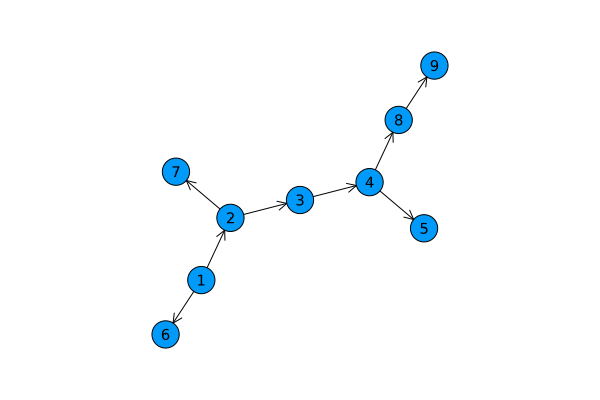

In [80]:
graphplot(Grandom, names = 1:9, nodeshape=:circle, aspect_ratio=1, nodesize=0.2, curvature_scalar = 0, fontsize = 10)

We can be a bit more fancy:

In [81]:
using Interact;

WebIO._IJuliaInit()

In [82]:
@manipulate for i in 2:9; # does not like graph with one vertex
    graphplot(Grandom[1:i], names = 1:i, nodeshape=:circle, aspect_ratio=1, nodesize=0.2, curvature_scalar = 0, fontsize = 10)
  end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 9, :min => 2, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(5), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/thofma/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/thofma/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/thofma/.julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), Asset("css", nothing, "/Users/thofma/.julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), Asset("css", nothing, "/Users/thofma/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x000000010b7a2a40, Task (runnable) @0x000000010b7a2a40), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"18443563711073343068\",\"id\":\"16045464040710181822\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"18443563711073343068\",\"id\":\"4056155052028485995\",\"type\":\"observable\"})};\n    var self = thi

### The neighbor graph

By determining all neighbors, we can determine the whole neighbor graph!

In [83]:
function all_neighbors_up_to_isometry(L::ZZLat, p)
  # keep L here
  res = [L]
  for _v in Hecke.cartesian_product_iterator(0:(p - 1), rank(L))
    v = QQ.(collect(_v))
    m = ZZ(Hecke.inner_product(rational_span(L), v, v))
    if mod(m, p) == 0
      while true
        w = v + QQ.([rand(-10:10) * p for i in 1:rank(L)])
        mm = ZZ(Hecke.inner_product(rational_span(L), w, w))
        if mod(mm, p^2) == 0
          _L =  neighbor(L, w, p)
          @assert isintegral(_L)
          #if !isintegral(_L)
            #continue
          #else
            if any(M -> is_isometric(M, _L), res)
              break
            else
              push!(res, _L)
              break
            end
          #end
       end
      end
    end
  end
  # drop L
  popfirst!(res)
  return res
end

function neighbor_graph(L::ZZLat, p)
  work_list = [L]
  edges = []
  vertices = [L]
  neighbor_cache = Dict()
  while !isempty(work_list)
    M = pop!(work_list)
    M_neighbors = all_neighbors_up_to_isometry(M, p)
    neighbor_cache[M] = M_neighbors
    for N in M_neighbors
      if any(NN -> is_isometric(NN, N), vertices)
        continue
      else
        push!(vertices, N)
        push!(work_list, N)
      end
    end
  end
  for M in vertices
    M_neighbors = neighbor_cache[M]
    for N in M_neighbors
      for MM in vertices
        if is_isometric(N, MM)
          push!(edges, (M, MM))
        end
      end
    end
  end
  G = Graphs.Graph(length(vertices))
  D = Dict(vertices[i] => i for i in 1:length(vertices))
  for e in edges
    Graphs.add_edge!(G, D[e[1]], D[e[2]])
  end
  return G
end

neighbor_graph (generic function with 1 method)

In [84]:
all_neighbors_up_to_isometry(L, 5)

2-element Vector{ZZLat}:
 Integer lattice of rank 3 and degree 3
 Integer lattice of rank 3 and degree 3

In [85]:
G = neighbor_graph(L, 5)

{9, 14} undirected simple Int64 graph

Let's plot this!

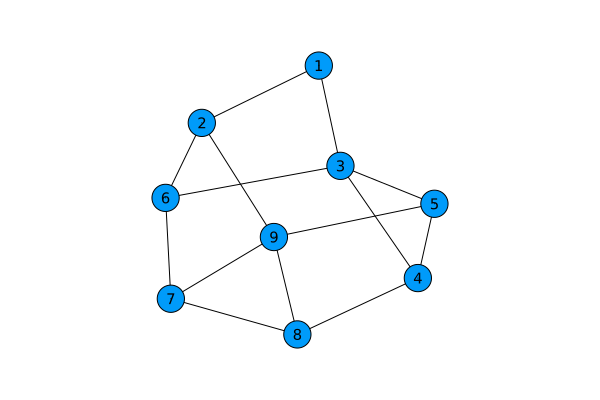

In [86]:
graphplot(G, names = 1:length(G), nodeshape=:circle, aspect_ratio=1, nodesize=0.2, curvature_scalar = 0, fontsize = 10)

### Changing the prime

What happens if we choose a different (good) prime?

In [87]:
G = neighbor_graph(L, 7)

{9, 21} undirected simple Int64 graph

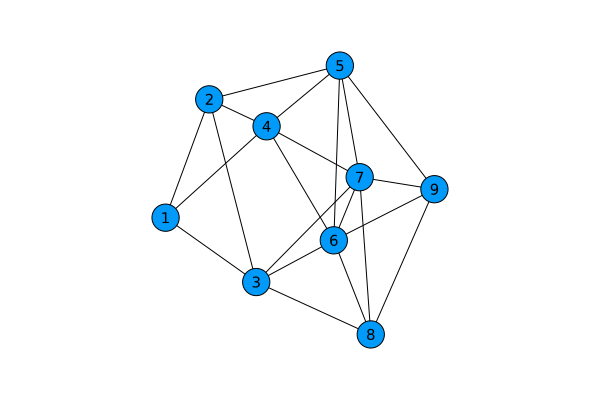

In [88]:
graphplot(G, names = 1:length(G), nodeshape=:circle, aspect_ratio=1, nodesize=0.2, curvature_scalar = 0, fontsize = 10)

This is a different graph! For example, vertex $1$ has degree $3$.

Something interesting for $p = 13$

In [89]:
G = neighbor_graph(L, 13)

{9, 27} undirected simple Int64 graph

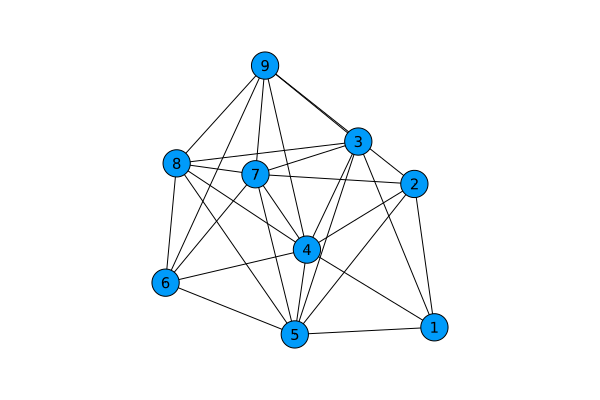

In [90]:
graphplot(G, names = 1:length(G), nodeshape=:circle, aspect_ratio=1, nodesize=0.2, curvature_scalar = 0, fontsize = 10)

There is a vertex with degree $8$!. Since $8 + 1 = 9 = \lvert \operatorname{gen}(L)\rvert$, this lattice and all its neighbors are representative for all classes in the genus!

## Another example

In [91]:
L = Zlattice(; gram = matrix(ZZ, [[2, 0, 1], [0, 2, 0], [1, 0, 496]])) # 3.1982.3964.50.1

Integer lattice of rank 3 and degree 3
with gram matrix
[2   0     1]
[0   2     0]
[1   0   496]

In [92]:
factor(ZZ(discriminant(L)))

-1 * 2 * 991

In [93]:
G = neighbor_graph(L, 3)

{50, 79} undirected simple Int64 graph

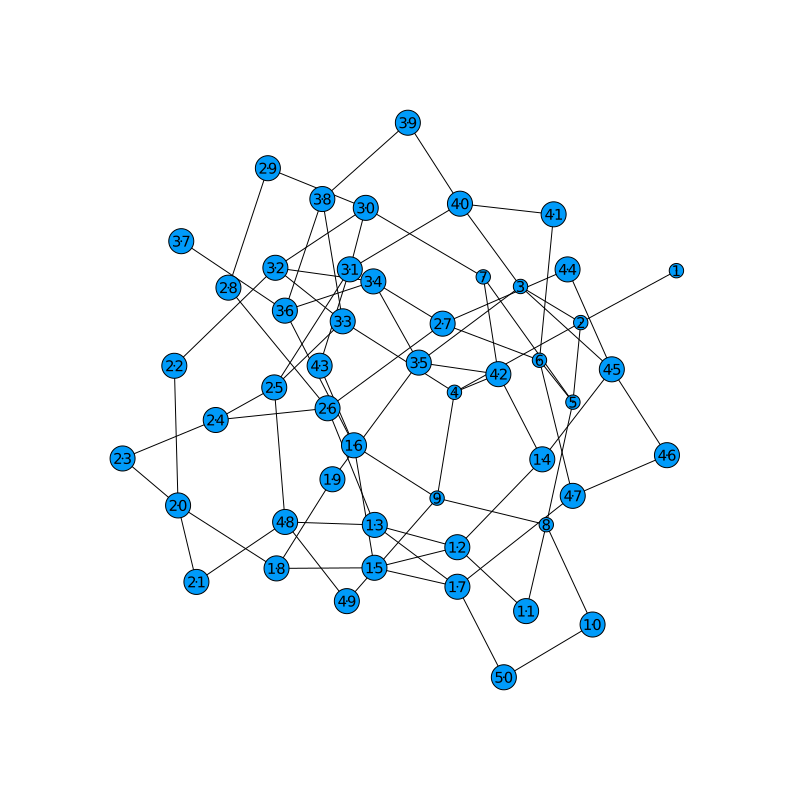

In [94]:
graphplot(G, names = 1:length(G), nodeshape=:circle, markersize=.12, aspect_ratio=1, nodesize=0.15, curvature_scalar = 0, fontsize = 10, size = (800, 800))

## Enumerating lattices

Question: Find the set $S$ of all (up to isometry) lattices $L$ with certain properties.

For example: Find all positive definite integer lattices $L$ with $\operatorname{rank}(L) = 4$ and $\lvert \det(L) \rvert \leq 50$.

This is a finite set! Can we compute it?

1. Find $\mathcal{G} = \{ \operatorname{genus}(L) \mid L \in S \}$. This enumeration of genera can be done using only the rank and determinant bound.
2. For each $G \in \mathcal{G}$, find the isometry classes of lattices in $G$.

The genera of positive definite integer lattices of determinant $1$:

In [95]:
G, = integer_genera((4, 0), 1)

1-element Vector{ZZGenus}:
 Genus symbol: I_(4, 0)

In [96]:
L = representative(G)

Integer lattice of rank 4 and degree 4
with gram matrix
[4   0   3   2]
[0   2   1   1]
[3   1   3   2]
[2   1   2   2]

In [97]:
genus_representatives(L)

1-element Vector{ZZLat}:
 Integer lattice of rank 4 and degree 4

Now for all possible determinants:

In [98]:
res = []
for i in 1:50
    for G in integer_genera((4, 0), i)
        append!(res, genus_representatives(representative(G)))
    end
end
length(res)

645

Thus (up to isometry), there are 645 positive definite integer lattices with rank $4$ and determinant bounded by $50$.

# Torsion quadratic modules

A torsion quadratic module is the quotient $T = L/M$ of two integer lattices $L$ and $M$ of the same rank, equipped with induced maps

$$ b \colon T \times T \to \mathbf{Q}/n\mathbf{Z}$$


and

$$ q \colon T \to \mathbf{Q}/m\mathbf{Z}.$$

Arise naturally when
- constructing overlattices, or
- gluing lattices together.

If $L$ is an integral lattice with dual $L^\vee$, then the torsion quadratic module $D_L = L^\vee/L$ is the *discriminant group* of $L$.

### Construction and properties

In [99]:
L = root_lattice(:E, 8)

Integer lattice of rank 8 and degree 8
with gram matrix
[ 2   -1    0    0    0    0    0    0]
[-1    2   -1    0    0    0    0    0]
[ 0   -1    2   -1    0    0    0   -1]
[ 0    0   -1    2   -1    0    0    0]
[ 0    0    0   -1    2   -1    0    0]
[ 0    0    0    0   -1    2   -1    0]
[ 0    0    0    0    0   -1    2    0]
[ 0    0   -1    0    0    0    0    2]

In [100]:
M = 2*L;

In [101]:
T = torsion_quadratic_module(L, M)

Finite quadratic module
  over integer ring
Abelian group: (Z/2)^8
Bilinear value module: Q/2Z
Quadratic value module: Q/4Z
Gram matrix quadratic form: 
[2   1   0   0   0   0   0   0]
[1   2   1   0   0   0   0   0]
[0   1   2   1   0   0   0   1]
[0   0   1   2   1   0   0   0]
[0   0   0   1   2   1   0   0]
[0   0   0   0   1   2   1   0]
[0   0   0   0   0   1   2   0]
[0   0   1   0   0   0   0   2]

In [102]:
modulus_bilinear_form(T), modulus_quadratic_form(T)

(2, 4)

In [103]:
elementary_divisors(T) |> print

ZZRingElem[2, 2, 2, 2, 2, 2, 2, 2]

Let's construct a lattice between $M$ and $L$.

In [104]:
S, StoT = subgroup(T, [gen(T, 1), gen(T, 2)]); order(S)

4

Thus $S \leq L/M$ corresonds to $M \subseteq N \subseteq L$ with index $4$.

To find $N$ we need to lift generators along $L \to L/M$.

In [105]:
lift.(gens(S))

2-element Vector{Vector{QQFieldElem}}:
 [1, 0, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0]

In [106]:
N = M + lattice_in_same_ambient_space(L, matrix(QQ, lift.(gens(S))))

Integer lattice of rank 8 and degree 8
with gram matrix
[ 2   -1    0    0    0    0    0    0]
[-1    2   -2    0    0    0    0    0]
[ 0   -2    8   -4    0    0    0   -4]
[ 0    0   -4    8   -4    0    0    0]
[ 0    0    0   -4    8   -4    0    0]
[ 0    0    0    0   -4    8   -4    0]
[ 0    0    0    0    0   -4    8    0]
[ 0    0   -4    0    0    0    0    8]

In [107]:
index(N, M)

4

## Niemeier lattices

A Niemeier lattice is a unimodular even lattice of rank $24$. If $L$ is a lattice, then

$$ \Phi_L = \{ x \in L \mid x^2 = 2 \}$$

is the set of *roots* of $L$ and $R(L) = \langle \Phi_L \rangle_{\mathbf{Z}} \subseteq L$ is the root lattice of $L$. Such a root lattice is determined up to isometry by the corresponding Dynkin diagram/root system.



Niemeier (1974): Up to isometry there are exactly 24 Niemeier lattices. Every Niemeier lattice is determined uniquely by $R(L)$. The 24 root systems are

$$ \emptyset, A_1^{\oplus 24}, A_2^{\oplus 12}, \dotsc, A_9^{\oplus 2} \perp D_6,\dotsc,$$


Let's construct the Niemeier lattice $L$ corresponding to $A_9^{\oplus 2} \perp D_6$. We begin by constructing the root lattice:

In [108]:
RL, = direct_sum([root_lattice(:A, 9), root_lattice(:A, 9), root_lattice(:D, 6)]);

We know that $R(L) \subseteq L \subseteq R(L)^\vee$. Thus $L$ corresponds to a subgroup $S \leq D_{R(L)}$ of the discriminant group $D_{R(L)}$.

- Since $L$ is unimodular, we must have $\lvert S \rvert^2 = \lvert D_{R(L)} \rvert$.
- Since $L$ is even, we must have that $S$ is totally isotropic.

In [109]:
DL = discriminant_group(RL)

Finite quadratic module
  over integer ring
Abelian group: (Z/2)^2 x (Z/10)^2
Bilinear value module: Q/Z
Quadratic value module: Q/2Z
Gram matrix quadratic form: 
[3//2   1//2       0       0]
[1//2   3//2       0    1//2]
[   0      0   9//10       0]
[   0   1//2       0   9//10]

In [110]:
A = abelian_group(DL)

GrpAb: (Z/2)^2 x (Z/10)^2

In [111]:
overlattices_and_submodules = []
for (S, StoDL) in submodules(DL, order = 20)
    M = RL + lattice(ambient_space(RL), matrix(QQ, lift.(StoDL.(gens(S)))), isbasis = false)
    push!(overlattices_and_submodules, (M, S))
end

Let's look at those overlattices:

In [112]:
M, S = overlattices_and_submodules[1];
is_integral(M)

false

In [113]:
Hecke.gram_matrix_quadratic(S)

[8//5      0      0]
[   0      1   1//2]
[   0   1//2   1//2]

In [114]:
findfirst(((M, S),) -> is_integral(M) && !is_even(M), overlattices_and_submodules)

195

In [115]:
M, S = overlattices_and_submodules[195]; is_integral(M), is_even(M)

(true, false)

In [116]:
is_totally_isotropic(S)

false

In [117]:
findfirst(((M, S),) -> is_integral(M) && is_even(M), overlattices_and_submodules)

69

In [118]:
M, S = overlattices_and_submodules[69]; is_integral(M) && is_even(M)

true

We have found a Niemeier lattice, yay!

In [119]:
is_totally_isotropic(S)

true

Is it *the* Niemeier lattice with root sublattice of type $A_9^{\oplus 2} \perp D_6$?

In [120]:
roottype, = root_lattice_recognition(M); roottype |> print

[(:D, 6), (:A, 9), (:A, 9)]

Yes!

In [121]:
findall(((M, S),) -> is_integral(M) && is_even(M), overlattices_and_submodules)

4-element Vector{Int64}:
 69
 70
 87
 88

They all have identitcal root sublattices and are thus all isometric (by theory). Our isometry is a bit too slow to show this. (We are working on this.)

What about the other root systems?

We cannot use this naive approach, since there are in general way too many subgroups:

In [122]:
L, = direct_sum([root_lattice(:A, 1) for i in 1:24]);
abelian_group(discriminant_group(L))

GrpAb: (Z/2)^24

$(\mathbf{Z}/2\mathbf{Z})^{24}$ has too many subgroups of order $2^{12}$, namely $77184136346814161837268404381760884963259795$.

Also, not all even integral overlattices of $L$ have the correct root system, because more roots (elements of norm 2) might be added.

In [123]:
M = maximal_even_lattice(L); is_even(M), is_unimodular(M)

(true, true)

In [124]:
roottype, = root_lattice_recognition(M); roottype |> print

[(:E, 8), (:E, 8), (:E, 8)]

We started with $A_1^{\oplus 24}$ and ended with $E_8^{\oplus 3}$. In fact $M$ is *the* root lattice $E_8^{\oplus 3}$.

### Glueing lattices

We are given even integral lattices $R, S$ and we want to find an even integral $L$, such that
- $R$ and $S$ are primitive sublattices of $L$,
- $R \perp S \leq L$,
- $\operatorname{rank}(R) + \operatorname{rank}(S) = \operatorname{rank}(L)$

Such overlattices $L$ correspond to *glue maps*

$$ \gamma \colon H_R \to H_S $$

where $H_R \leq D_R$, $H_S \leq D_S$ are submodules and $\gamma$ is an anti-isometry.


In [125]:
V = quadratic_space(QQ, matrix(QQ, 8, 8 ,[2, -1, 0, 0, 0, 0, 0, 0, -1, 2, -1, 0, 0, 0, 0, 0, 0, -1, 2, -1, 0, 0, 0, -1, 0, 0, -1, 2, -1, 0, 0, 0, 0, 0, 0, -1, 2, -1, 0, 0, 0, 0, 0, 0, -1, 2, -1, 0, 0, 0, 0, 0, 0, -1, 2, 0, 0, 0, -1, 0, 0, 0, 0, 2]));
R = lattice(V, matrix(ZZ, 4, 8 ,[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 5, 4, 3, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0]));
S = lattice(V, matrix(ZZ, 4, 8, [1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]));

In [126]:
DR = discriminant_group(R); DS = discriminant_group(S); abelian_group(DS), abelian_group(DR)

(GrpAb: (Z/3)^2, GrpAb: (Z/3)^2)

In [127]:
import Hecke: submodules

function submodules(T::TorQuadMod)
    A = abelian_group(T)
    return (sub(T, T.(StoA.(gens(S)))) for (S, StoA) in subgroups(A, fun = (x, y) -> sub(x, y, false)))
end    

submodules (generic function with 4 methods)

In [128]:
glueings = []
for (HR, _) in submodules(DR)
    for (HS, _) in submodules(DS)
        fl, gamma = is_anti_isometric_with_anti_isometry(HR, HS)
        if fl
            push!(glueings, gamma)
        end
    end
end
length(glueings)

10

In [129]:
R + S == overlattice(glueings[1])

true

In [130]:
findfirst(M -> is_even(M) && is_unimodular(M), overlattice.(glueings))

10

In [131]:
L = overlattice(glueings[10])

Integer lattice of rank 8 and degree 8
with gram matrix
[ 2   -1    0    0    0    0    0    0]
[-1    2   -1    0    0    0    0    0]
[ 0   -1    2   -1    0    0    0   -1]
[ 0    0   -1    2   -1    0    0    0]
[ 0    0    0   -1    2   -1    0    0]
[ 0    0    0    0   -1    2   -1    0]
[ 0    0    0    0    0   -1    2    0]
[ 0    0   -1    0    0    0    0    2]

This is the root lattice $E_8$.

Let's find all the glueings with glueing groups $H_R = D_R$ and $H_S = D_S$. If $\gamma \colon D_R \to D_S$ is a fixed anti-isometry, then

$$ \{ H_R \to H_S \text{ anti-isometry}\} = \{ \sigma \circ \gamma \mid \sigma \in \mathrm{O}(D_R) \} $$

In [132]:
HR = DR; HS = DS; fl, gamma = is_anti_isometric_with_anti_isometry(HR, HS);
all_glueings = [hom(sigma) * gamma for sigma in orthogonal_group(HR)];
length(all_glueings)

8

In [133]:
overlats = [ overlattice(glue) for glue in all_glueings ]

8-element Vector{ZZLat}:
 Integer lattice of rank 8 and degree 8
 Integer lattice of rank 8 and degree 8
 Integer lattice of rank 8 and degree 8
 Integer lattice of rank 8 and degree 8
 Integer lattice of rank 8 and degree 8
 Integer lattice of rank 8 and degree 8
 Integer lattice of rank 8 and degree 8
 Integer lattice of rank 8 and degree 8

In [134]:
basis_matrix(overlats[1])

[1   0   0   0   0   0   0   0]
[0   1   0   0   0   0   0   0]
[0   0   1   0   0   0   0   0]
[0   0   0   1   0   0   0   0]
[0   0   0   0   1   0   0   0]
[0   0   0   0   0   1   0   0]
[0   0   0   0   0   0   1   0]
[0   0   0   0   0   0   0   1]

In [135]:
basis_matrix(overlats[2])

[   1      0   0      0      0   0   0   0]
[   0      1   0      0      0   0   0   0]
[2//3   1//3   1      0      0   0   0   0]
[   0      0   0      1      0   0   0   0]
[   0      0   0      0      1   0   0   0]
[2//3   1//3   0   1//3   2//3   1   0   0]
[   0      0   0      0      0   0   1   0]
[   0      0   0      0      0   0   0   1]

In [136]:
all(M -> is_isometric(L, M), overlats)

true

Glueings are not unique, but their isometry class is!